In [15]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
from scipy import stats

In [26]:
sites = ['Dartmouth', 'Jefferson','Emory', 'UTSW']
BAI_high = 16
BAI_low = 10
BDI_high = 17
BDI_low = 10

sel_sub = pd.DataFrame([])
subs = []
for site in sites:
#     df = pd.read_excel(r'./' + site + '_neuropsych.xlsx',engine="openpyxl")
    df = pd.read_excel(r'./' + site + '_neuropsych.xlsx')
    for i in df.index:
        #gap = df.iloc[i]['Time between report and implant (days)']
        BDI = df.iloc[i]['BDI']
        BAI = df.iloc[i]['BAI']
        sub = df.iloc[i]['Subject Number']
        #if gap < 183 and np.isnan(BDI)==False and np.isnan(BAI)==False:
        if np.isnan(BDI)==False and np.isnan(BAI)==False:
            sel_sub = sel_sub.append({
                'subject':sub,
                'BDI':BDI,
                'BAI':BAI
                }, ignore_index = True)
sel_sub

,BAI,BDI,subject
0,3.0,6.0,32.0
1,4.0,3.0,33.0
2,27.0,14.0,98.0
3,11.0,39.0,100.0
4,9.0,8.0,116.0
...,...,...,...
161,6.0,0.0,457.0
162,18.0,13.0,474.0
163,5.0,3.0,478.0
164,4.0,3.0,531.0


In [4]:
df = get_data_index('r1')
df_subs = df['subject'].unique()
df_select = pd.DataFrame([])
df_subs
tmp = []
select = []
for sub in df_subs:
    num = int(sub[2:5])
    for i in sel_sub.index:
        sel = sel_sub.iloc[i]['subject']
        if sel == num:
            df_select = df_select.append({
                'subject':sub,
                'BDI':sel_sub.iloc[i]['BDI'],
                'BAI':sel_sub.iloc[i]['BAI']
                }, ignore_index = True)
df_select

,BAI,BDI,subject
0,0.0,2.0,R1008J
1,2.0,1.0,R1010J
2,2.0,12.0,R1013E
3,7.0,15.0,R1015J
4,14.0,22.0,R1019J
...,...,...,...
136,15.0,17.0,R1566D
137,18.0,12.0,R1568E
138,1.0,23.0,R1582E
139,16.0,32.0,R1584J


In [5]:
trial_df = pd.DataFrame([])
list_df = pd.DataFrame([])

experiments = ['FR1', 'catFR1']

for sub in df_select['subject']:
    try:
        for exp in experiments:
            localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        

            for loc in localizations:
                montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            

                for mont in montages: # iterate over montages            
                    data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                    sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()

                    for sess in sessions: 
                        reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                        evs = reader.load('task_events')
                        word_evs = evs[evs['type']=='REC_WORD']

                        #exclude practice lists 
                        lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                        corr_recs = len(word_evs[word_evs['intrusion']==0])
                        ELIs = len(word_evs[word_evs['intrusion']==-1])
                        PLIs = len(word_evs[word_evs['intrusion']>0])
                        total_ints = ELIs + PLIs
                        total_trials = corr_recs + total_ints

                        trials = [] #make list of event numbers of analysis
                        for list_num in word_evs['list'][word_evs['list']>0].unique():
                            list_events=word_evs[word_evs['list']==list_num]
                            if len(list_events)>0: 
                                for i in range(0,len(list_events)):
                                    trials.append(list_events.index[i])
                            PLI = len(list_events[list_events['intrusion']>0])
                            ELI = len(list_events[list_events['intrusion']==-1])
                            correc = len(list_events[list_events['intrusion']==0])
                            row = df_select[df_select['subject']==sub] #get row of BAI/BDI scores for subject
                            list_df = list_df.append({ #create dataframe of events for analysis grouped by list ##should I filter out lists with no events?
                                'subject':sub,
                                'session': sess,
                                'experiment': exp,
                                'list': list_num,
                                'number of correct recalls': correc,
                                'number of extra-list intrusions': ELI,
                                'number of prior-list intrusions': PLI,
                                'total number of intrusions': ELI+PLI,
                                'BAI':int(row['BAI'].values),
                                'BDI':int(row['BDI'].values) 
                                },ignore_index=True) 
                        trial_df = trial_df.append({ #create dataframe of events for analysis grouped by session
                            'subject':sub,
                            'session': sess,
                            'montage': mont,
                            'localization': loc,
                            'experiment': exp,
                            'number of lists': lists,
                            'number of correct recalls': corr_recs,
                            'number of extra-list intrusions': ELIs,
                            'number of prior-list intrusions': PLIs,
                            'total number of intrusions': total_ints,
                            'total number of trials left': total_trials,
                            'trials for analysis': trials
                            },ignore_index=True) 
    except:
        print('Failed for subject:', sub)
list_df

,BAI,BDI,experiment,list,number of correct recalls,number of extra-list intrusions,number of prior-list intrusions,session,subject,total number of intrusions
0,2.0,1.0,FR1,1.0,2.0,0.0,0.0,0.0,R1010J,0.0
1,2.0,1.0,FR1,2.0,3.0,0.0,1.0,0.0,R1010J,1.0
2,2.0,1.0,FR1,3.0,3.0,0.0,2.0,0.0,R1010J,2.0
3,2.0,1.0,FR1,5.0,3.0,0.0,1.0,0.0,R1010J,1.0
4,2.0,1.0,FR1,6.0,2.0,0.0,1.0,0.0,R1010J,1.0
...,...,...,...,...,...,...,...,...,...,...
5998,11.0,8.0,catFR1,8.0,10.0,0.0,0.0,1.0,R1542J,0.0
5999,11.0,8.0,catFR1,9.0,8.0,0.0,0.0,1.0,R1542J,0.0
6000,11.0,8.0,catFR1,10.0,8.0,0.0,0.0,1.0,R1542J,0.0
6001,11.0,8.0,catFR1,11.0,6.0,0.0,1.0,1.0,R1542J,1.0


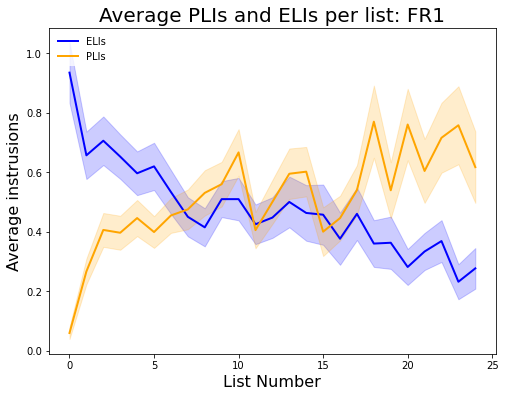

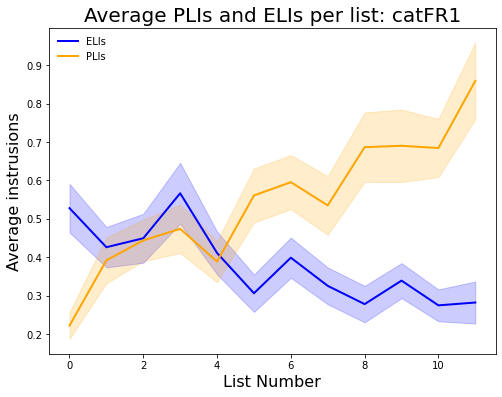

In [27]:
#BEGINNING OF LIST-LEVEL ANALYSES
experiments = ['FR1', 'catFR1']
colors = ['blue', 'orange']

exp_sum_df = pd.DataFrame([])
for exp in experiments:
    if exp=='FR1':
        nlist = 25
    elif exp=='catFR1': ##there are 30 subjects who ran CatFR1 with 25 lists rather than 12. Need to figure out how to interpret the second half of those sessions
        nlist = 12
    for i in range(1,nlist+1):
        exp_list_df = list_df[list_df['experiment']==exp]
        list_sel = exp_list_df[exp_list_df['list']==i]
        correc = np.mean(list_sel['number of correct recalls'])
        ELI = np.mean(list_sel['number of extra-list intrusions'])
        ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        PLI = np.mean(list_sel['number of prior-list intrusions'])
        PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        exp_sum_df = exp_sum_df.append({
            'experiment':list_sel.iloc[0]['experiment'],
            'list':i,
            'average correct recalls':correc,
            'average ELIs':ELI,
            'ELI_sem':ELI_sem,
            'average PLIs':PLI,
            'PLI_sem':PLI_sem
        }, ignore_index=True)
    
    sel_sum_df = exp_sum_df.query("experiment=='"+exp+"'")
    #sel_sum_df = exp_sum_df[exp_sum_df['experiment']==exp]
    lst = list(sel_sum_df['list'])
    meanELIs = sel_sum_df['average ELIs']
    meanPLIs = sel_sum_df['average PLIs']
    semELIs = sel_sum_df['ELI_sem']
    semPLIs = sel_sum_df['PLI_sem']
    
    plt.figure(figsize=(8,6))
#     e = plt.plot(lst, meanELIs)
#     p = plt.plot(lst, meanPLIs)
    plt.plot(range(0,len(meanELIs)),meanELIs,linewidth=2,color=colors[0])
    plt.fill_between(range(0,len(meanELIs)),meanELIs-semELIs,meanELIs+semELIs,color=colors[0],alpha=0.2)
    plt.plot(range(0,len(meanPLIs)),meanPLIs,linewidth=2,color=colors[1])
    plt.fill_between(range(0,len(meanPLIs)),meanPLIs-semPLIs,meanPLIs+semPLIs,color=colors[1],alpha=0.2)
    plt.title('Average PLIs and ELIs per list: '+exp, fontsize=20)
    plt.xlabel('List Number',fontsize=16)
    plt.ylabel('Average instrusions',fontsize=16)
    plt.legend(('ELIs','PLIs'),loc='upper left',edgecolor="None")

# long_cat = list_df[np.logical_and(list_df['experiment']==exp, list_df['list']>12)]
# long_cat['subject'].unique()

,ELI_sem,PLI_sem,average ELIs,average PLIs,average correct recalls,correct recall_sem,experiment,level,list,metric
0,0.166653,0.065166,0.655172,0.137931,3.206897,3.206897,catFR1,high,1.0,BDI
1,0.133333,0.177682,0.533333,0.466667,3.266667,3.266667,catFR1,high,2.0,BDI
2,0.129301,0.110497,0.419355,0.387097,3.387097,3.387097,catFR1,high,3.0,BDI
3,0.233826,0.168530,0.692308,0.461538,2.884615,2.884615,catFR1,high,4.0,BDI
4,0.123324,0.122624,0.424242,0.393939,2.606061,2.606061,catFR1,high,5.0,BDI
5,0.091017,0.215385,0.153846,0.615385,3.000000,3.000000,catFR1,high,6.0,BDI
6,0.116790,0.163299,0.266667,0.600000,3.333333,3.333333,catFR1,high,7.0,BDI
7,0.124329,0.183162,0.344828,0.482759,3.137931,3.137931,catFR1,high,8.0,BDI
8,0.141421,0.280000,0.400000,0.720000,3.080000,3.080000,catFR1,high,9.0,BDI
9,0.097674,0.315621,0.300000,0.666667,3.200000,3.200000,catFR1,high,10.0,BDI


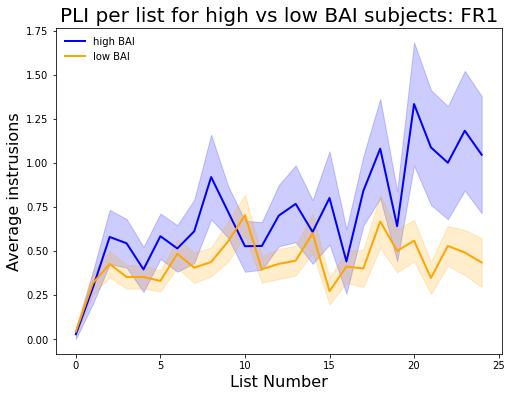

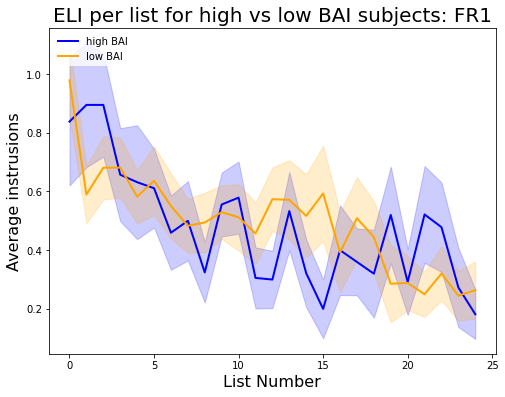

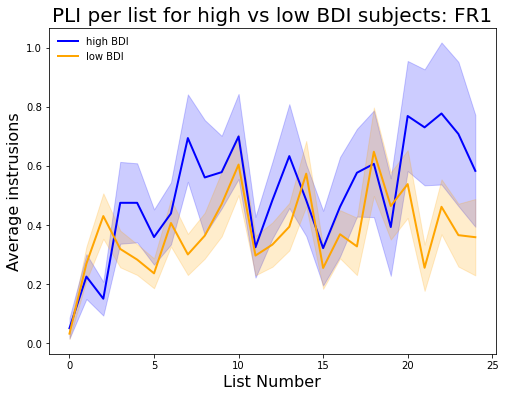

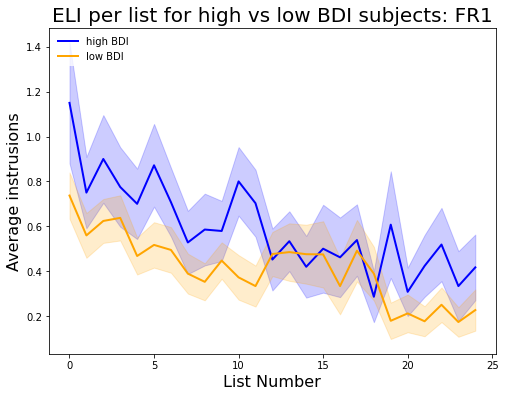

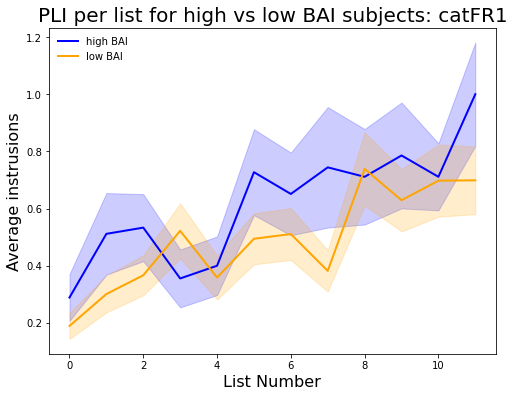

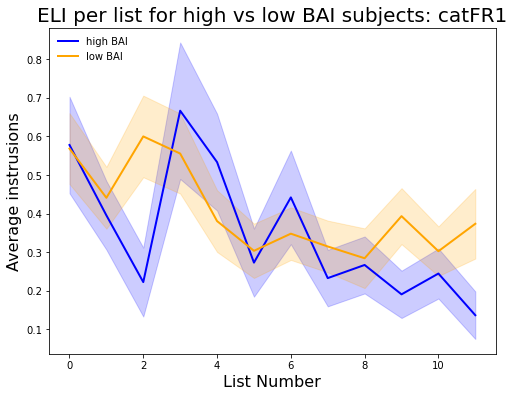

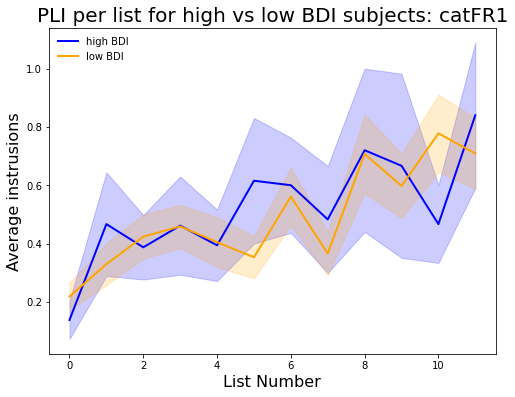

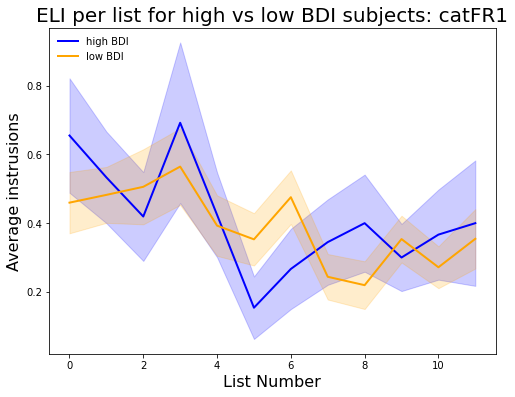

In [49]:
dependents = ['PLI', 'ELI']
metrics = ['BAI','BDI']
levels = ['high','low']
# split_sum_df = pd.DataFrame([])
exp_list_df_highA = exp_list_df[exp_list_df['BAI']>BAI_high]
exp_list_df_lowA = exp_list_df[exp_list_df['BAI']<BAI_low]
exp_list_df_highD = exp_list_df[exp_list_df['BDI']>BDI_high]
exp_list_df_lowD = exp_list_df[exp_list_df['BDI']<BDI_low]

for exp in experiments:
    for met in metrics:
        for dep in dependents:
            split_sum_df = pd.DataFrame([])
            exp_list_df = list_df[list_df['experiment']==exp]
            exp_list_df_highA = exp_list_df[exp_list_df['BAI']>BAI_high]
            exp_list_df_lowA = exp_list_df[exp_list_df['BAI']<BAI_low]
            exp_list_df_highD = exp_list_df[exp_list_df['BDI']>BDI_high]
            exp_list_df_lowD = exp_list_df[exp_list_df['BDI']<BDI_low]
            if exp=='FR1':
                nlist = 25
            elif exp=='catFR1':
                nlist = 12
            if met=='BAI':
                exp_list_df_high = exp_list_df_highA
                exp_list_df_low = exp_list_df_lowA
            elif met=='BDI':
                exp_list_df_high = exp_list_df_highD
                exp_list_df_low = exp_list_df_lowD
            for lev in levels:
                if lev =='high':
                    exp_list_df_filt = exp_list_df_high
                elif lev=='low':
                    exp_list_df_filt = exp_list_df_low
                for i in range(1,nlist+1):
                    list_sel = exp_list_df_filt[exp_list_df_filt['list']==i]
                    correc = np.mean(list_sel['number of correct recalls'])
                    correc_sem = scipy.stats.sem(list_sel['number of correct recalls'],axis=0,ddof=1,nan_policy='omit')
                    ELI = np.mean(list_sel['number of extra-list intrusions'])
                    ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    PLI = np.mean(list_sel['number of prior-list intrusions'])
                    PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    split_sum_df = split_sum_df.append({
                        'experiment':list_sel.iloc[0]['experiment'],
                        'list':i,
                        'average correct recalls':correc,
                        'correct recall_sem':correc,
                        'average ELIs':ELI,
                        'ELI_sem':ELI_sem,
                        'average PLIs':PLI,
                        'PLI_sem':PLI_sem,
                        'metric':met,
                        'level':lev
                    }, ignore_index=True)
            lst = list(split_sum_df['list'])
            high_ints = list(split_sum_df[split_sum_df['level']=='high']['average '+dep+'s'])
            low_ints = list(split_sum_df[split_sum_df['level']=='low']['average '+dep+'s'])
            sem_high = split_sum_df[split_sum_df['level']=='high'][dep+'_sem']
            sem_low = split_sum_df[split_sum_df['level']=='low'][dep+'_sem']

            plt.figure(figsize=(8,6))
            plt.plot(range(0,len(high_ints)),high_ints,linewidth=2,color=colors[0])
            plt.fill_between(range(0,len(high_ints)),high_ints-sem_high,high_ints+sem_high,color=colors[0],alpha=0.2)
            plt.plot(range(0,len(low_ints)),low_ints,linewidth=2,color=colors[1])
            plt.fill_between(range(0,len(low_ints)),low_ints-sem_low,low_ints+sem_low,color=colors[1],alpha=0.2)
            plt.title(dep+' per list for high vs low '+met+' subjects: '+exp, fontsize=20)
            plt.xlabel('List Number',fontsize=16)
            plt.ylabel('Average instrusions',fontsize=16)
            plt.legend(('high '+met,'low '+met),loc='upper left',edgecolor="None")
split_sum_df

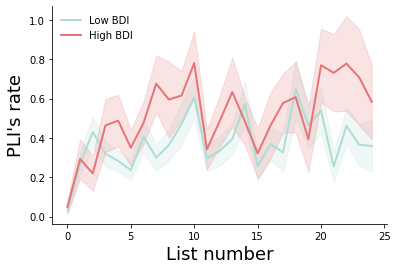

In [48]:
colors=['#AFDDD5','#E77577']

mean_low=FR_sum_df_low['average PLIs']
sem_low=FR_sum_df_low['sem PLIs']
mean_high=FR_sum_df_high['average PLIs']
sem_high=FR_sum_df_high['sem PLIs']


# fig=plt.figure(figsize=(5,4.5));#ax=plt.subplot(121)
plt.plot(range(0,len(mean_low)),mean_low,linewidth=2,color=colors[0])
plt.fill_between(range(0,len(mean_low)),mean_low-sem_low,mean_low+sem_low,color=colors[0],alpha=0.2)
plt.plot(range(0,len(mean_high)),mean_high,linewidth=2,color=colors[1])
plt.fill_between(range(0,len(mean_high)),mean_high-sem_high,mean_high+sem_high,color=colors[1],alpha=0.2)

plt.legend(('Low BDI','High BDI'),loc='upper left',edgecolor="None")
plt.xlabel('List number',fontsize=18)
plt.ylabel("PLI's rate",fontsize=18)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
# plt.grid(b=None)


In [50]:
#BEGINNING OF SESSION LEVEL ANALYSES

catFR_df_filter = pd.DataFrame([])
FR_df_filter = pd.DataFrame([])
df_filter = pd.DataFrame([])

for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        row = df_select[df_select['subject'] == sub]
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        allrec = trial_df.iloc[i]['total number of trials left']
        lists = trial_df.iloc[i]['number of lists']
        exp = trial_df.iloc[i]['experiment']
        PLI_scaled = float(pli/correc)
        ELI_scaled = float(eli/correc)
        correc_scaled = float(correc/lists)
#         PLI_scaled = float(pli/allrec)
#         ELI_scaled = float(eli/allrec)
#         correc_scaled = float(correc/allrec)
        if allrec > 0:
            df_filter = df_filter.append({
                'subject':sub,
                'experiment':exp,
                'correct recalls':correc,
                'ELIs':eli,
                'PLIs':pli,
                'total ints': eli+pli,
                'lists':lists,
                'correct recalls scaled':correc_scaled,
                'all recalls':allrec,
                'ELI scaled':ELI_scaled,
                'PLI scaled':PLI_scaled,
                'total scaled':ELI_scaled+PLI_scaled,
                'BAI':int(row['BAI'].values),
                'BDI':int(row['BDI'].values)
            }, ignore_index = True)
        else:
            print('removed row =', i, sub, exp)
    except:
        print('removed row =', i, sub, exp)


FR_df_filter = df_filter.query("experiment=='FR1'")
catFR_df_filter = df_filter.query("experiment=='catFR1'")
df_filter

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


removed row = 3 R1015J FR1
removed row = 63 R1100D FR1
removed row = 64 R1100D FR1


,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,all recalls,correct recalls,correct recalls scaled,experiment,lists,subject,total ints,total scaled
0,2.0,1.0,0.035714,2.0,0.214286,12.0,70.0,56.0,2.434783,FR1,23.0,R1010J,14.0,0.250000
1,2.0,1.0,0.070175,4.0,0.105263,6.0,67.0,57.0,2.478261,FR1,23.0,R1010J,10.0,0.175439
2,2.0,12.0,0.000000,0.0,0.050000,4.0,84.0,80.0,4.000000,catFR1,20.0,R1013E,4.0,0.050000
3,7.0,15.0,0.062500,1.0,0.187500,3.0,20.0,16.0,1.777778,catFR1,9.0,R1015J,4.0,0.250000
4,0.0,4.0,0.016807,2.0,0.058824,7.0,128.0,119.0,4.760000,FR1,25.0,R1020J,9.0,0.075630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,11.0,8.0,0.021739,2.0,0.010870,1.0,95.0,92.0,7.666667,FR1,12.0,R1542J,3.0,0.032609
358,11.0,8.0,0.033333,3.0,0.022222,2.0,95.0,90.0,7.500000,FR1,12.0,R1542J,5.0,0.055556
359,11.0,8.0,0.063830,6.0,0.010638,1.0,101.0,94.0,7.833333,FR1,12.0,R1542J,7.0,0.074468
360,11.0,8.0,0.022472,2.0,0.011236,1.0,92.0,89.0,7.416667,catFR1,12.0,R1542J,3.0,0.033708


total PLI = 1810.0
total ELI = 1448.0
mean diff = 0.9822355126872561
median diff = 1.0


Text(0.9822355126872561, 15, '  Mean: 0.0')

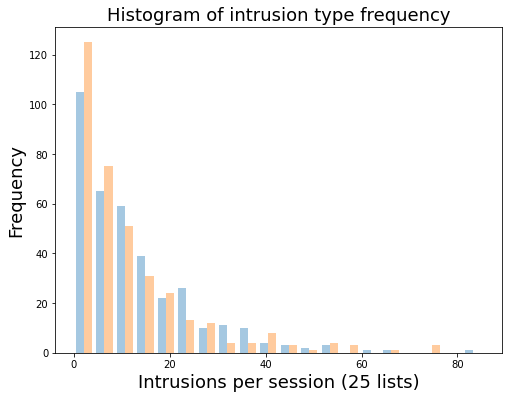

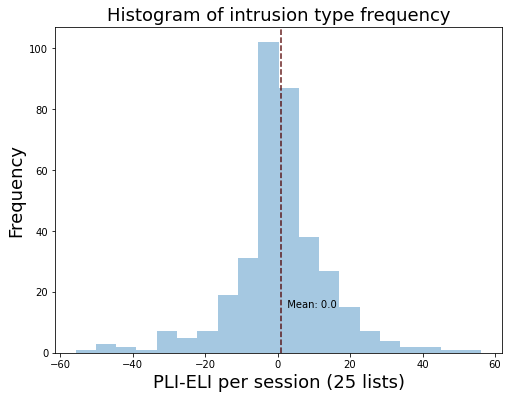

In [52]:
#get intrusion per session counts to generate a histogram
df_int = pd.DataFrame([])
for i in df_filter.index:
    sub = df_filter.iloc[i]['subject']
    exp = df_filter.iloc[i]['experiment']
    PLI = df_filter.iloc[i]['PLIs']
    ELI = df_filter.iloc[i]['ELIs']
    lists = df_filter.iloc[i]['lists']
    sPLI = float(PLI/lists)*25
    sELI = float(ELI/lists)*25
    diff = sPLI-sELI
    df_int = df_int.append({
        'subject':sub,
        'experiment':exp,
        'ELIs':eli,
        'PLIs':pli,
        'lists':lists,
        'ELIs per session':sELI,
        'PLIs per session':sPLI,
        'PLI minus ELI per session':diff,
    }, ignore_index=True)

total_PLI = np.sum(df_int['PLIs'])
total_ELI = np.sum(df_int['ELIs'])
PLI_list = list(df_int['PLIs per session'])
ELI_list = list(df_int['ELIs per session'])
diff_list = list(df_int['PLI minus ELI per session'])

plt.figure(figsize=(8,6))
int_hist = plt.hist((PLI_list, ELI_list), 20,alpha=0.4)
plt.xlabel('Intrusions per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title('Histogram of intrusion type frequency',fontsize=18)

print('total PLI =', total_PLI)
print('total ELI =', total_ELI)

plt.figure(figsize=(8,6))
diff_hist = plt.hist(diff_list, 20,alpha=0.4)
plt.xlabel('PLI-ELI per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
# plt.title('Time Between Report and Implant: '+ site,fontsize=18)
plt.title('Histogram of intrusion type frequency',fontsize=18)
mean = np.mean(diff_list)
median = np.median(diff_list)

plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5)
plt.axvline(x=median, color='k', linestyle='--',alpha=0.6)
print('mean diff =', mean)
print('median diff =', median)

plt.text(mean,15,'  Mean: %.1f' %(mean/30))

In [53]:
#average across sessions from the same subject
avg_df = pd.DataFrame([])
sub_df = df_filter['subject'].unique()

for exp in experiments:
    exp_df_filter = df_filter[df_filter['experiment']==exp]
    exp_sub_df = exp_df_filter['subject'].unique()
    for sub in exp_sub_df:
        trials = exp_df_filter[exp_df_filter['subject']==sub]
        df_mean = trials.mean(axis=0)
        avg_eli = df_mean['ELI scaled']
        avg_pli = df_mean['PLI scaled']
        avg_int = df_mean['total scaled']
        avg_cor = df_mean['correct recalls scaled']
        avg_df = avg_df.append({
            'subject':sub,
            'experiment':exp,
            'average ELIs':avg_eli,
            'average PLIs':avg_pli,
            'average ints': avg_int,
            'average correct recalls':avg_cor,
            'BAI':df_mean['BAI'],
            'BDI':df_mean['BDI']
            }, ignore_index = True)

# catFR_avg_df = pd.DataFrame([])
# catFR_sub_df = catFR_df_filter['subject'].unique()
# for sub in catFR_sub_df:
#     trials = catFR_df_filter[catFR_df_filter['subject']==sub]
#     df_mean = trials.mean(axis=0)
#     avg_eli = df_mean['ELI scaled']
#     avg_pli = df_mean['PLI scaled']
#     avg_int = df_mean['total scaled']
#     avg_cor = df_mean['correct recalls scaled']
#     exp = trials.iloc[0]['experiment']
#     catFR_avg_df = catFR_avg_df.append({
#         'subject':sub,
#         'experiment':exp,
#         'average ELIs':avg_eli,
#         'average PLIs':avg_pli,
#         'average ints': avg_int,
#         'average correct recalls':avg_cor,
#         'BAI':df_mean['BAI'],
#         'BDI':df_mean['BDI']
#         }, ignore_index = True)
avg_df

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject
0,2.0,1.0,0.052945,0.159774,2.456522,0.212719,FR1,R1010J
1,0.0,4.0,0.016807,0.058824,4.760000,0.075630,FR1,R1020J
2,3.0,1.0,0.301205,0.168675,3.320000,0.469880,FR1,R1022J
3,4.0,2.0,0.013514,0.013514,3.523810,0.027027,FR1,R1023J
4,33.0,19.0,0.341463,0.195122,2.562500,0.536585,FR1,R1027J
...,...,...,...,...,...,...,...,...
143,5.0,6.0,0.062500,0.187500,3.200000,0.250000,catFR1,R1526J
144,18.0,16.0,0.025938,0.121146,9.638889,0.147085,catFR1,R1530J
145,12.0,21.0,0.229508,0.672131,5.083333,0.901639,catFR1,R1533J
146,24.0,17.0,0.064203,0.238134,4.001894,0.302337,catFR1,R1536J


In [54]:
mean=np.mean(avg_df[avg_df['experiment']=='FR1']['average ints'])
std=np.std(avg_df[avg_df['experiment']=='FR1']['average ints'], ddof=1)

print(avg_df[avg_df['experiment']=='FR1']['average ints'].std(ddof=1))
print(std)

0.6942809290643321
0.6942809290643321


In [55]:
FR_avg_df = avg_df.query("experiment == 'FR1'")
catFR_avg_df = avg_df.query("experiment == 'catFR1'")

FR_stats = FR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
catFR_stats = catFR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
#FR_stats.apply(zscore)
# for i in FR_avg_df.index:
FR_df_zscore = (FR_stats - FR_stats.mean())/FR_stats.std()
catFR_df_zscore = (catFR_stats - catFR_stats.mean())/catFR_stats.std()

FR_avg_df['zELI'] = FR_df_zscore['average ELIs']
FR_avg_df['zPLI'] = FR_df_zscore['average PLIs']
FR_avg_df['zints'] = FR_df_zscore['average ints']
FR_avg_df['zcorrec'] = FR_df_zscore['average correct recalls']

catFR_avg_df['zELI'] = catFR_df_zscore['average ELIs']
catFR_avg_df['zPLI'] = catFR_df_zscore['average PLIs']
catFR_avg_df['zints'] = catFR_df_zscore['average ints']
catFR_avg_df['zcorrec'] = catFR_df_zscore['average correct recalls']
catFR_avg_df

full_df=pd.concat((FR_avg_df,catFR_avg_df))
full_df

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject,zELI,zPLI,zints,zcorrec
0,2.0,1.0,0.052945,0.159774,2.456522,0.212719,FR1,R1010J,-0.479464,-0.172577,-0.378402,-0.748568
1,0.0,4.0,0.016807,0.058824,4.760000,0.075630,FR1,R1020J,-0.561603,-0.509105,-0.575856,1.316076
2,3.0,1.0,0.301205,0.168675,3.320000,0.469880,FR1,R1022J,0.084808,-0.142908,-0.008004,0.025381
3,4.0,2.0,0.013514,0.013514,3.523810,0.027027,FR1,R1023J,-0.569088,-0.660150,-0.645861,0.208059
4,33.0,19.0,0.341463,0.195122,2.562500,0.536585,FR1,R1027J,0.176312,-0.054744,0.088075,-0.653578
...,...,...,...,...,...,...,...,...,...,...,...,...
143,5.0,6.0,0.062500,0.187500,3.200000,0.250000,catFR1,R1526J,-0.394368,0.317323,-0.129719,-0.605887
144,18.0,16.0,0.025938,0.121146,9.638889,0.147085,catFR1,R1530J,-0.565327,-0.138621,-0.479559,2.919676
145,12.0,21.0,0.229508,0.672131,5.083333,0.901639,catFR1,R1533J,0.386545,3.647430,2.085399,0.425317
146,24.0,17.0,0.064203,0.238134,4.001894,0.302337,catFR1,R1536J,-0.386405,0.665254,0.048192,-0.166816


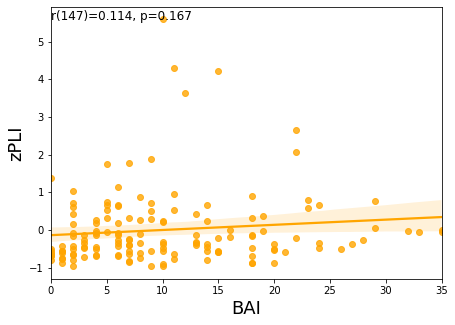

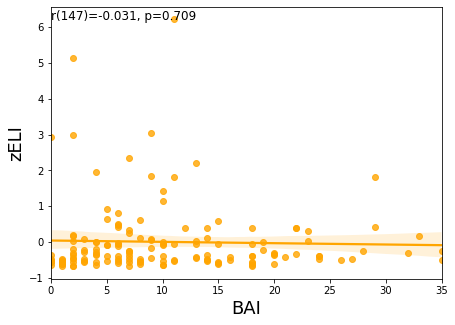

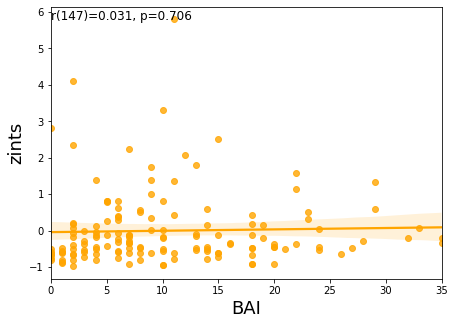

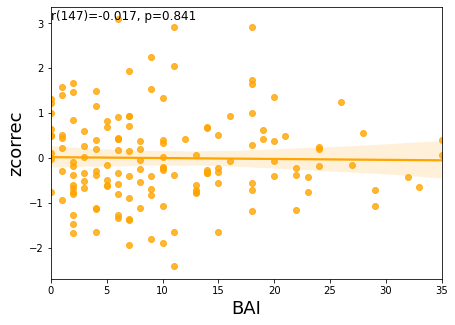

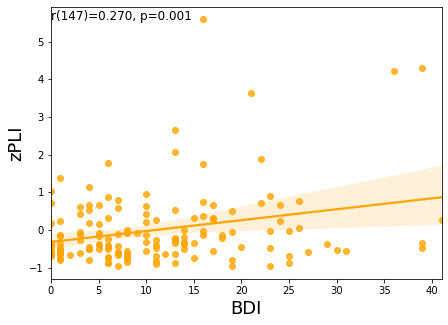

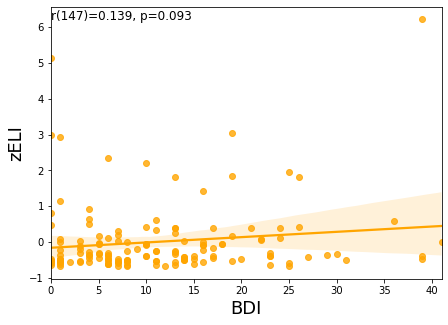

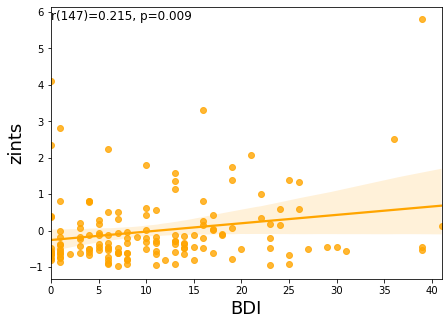

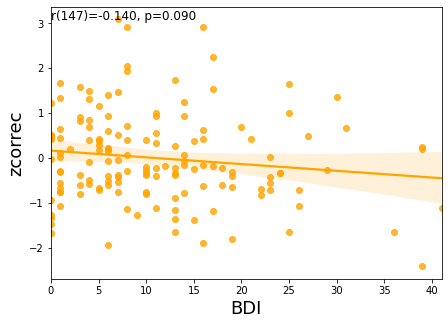

In [56]:
xs = ['BAI', 'BDI']
ys = ['zPLI', 'zELI', 'zints', 'zcorrec']
exp = 'both'

for xi in xs:
    for yi in ys:
 #'Average correct recalls'/'average ints'
        if exp == 'FR1':
            sel_df = FR_avg_df
        elif exp == 'catFR1':
            sel_df = catFR_avg_df
        elif exp == 'both':
            sel_df = full_df

        x = sel_df[xi]
        y = sel_df[yi]
        n = len(sel_df)

        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        grad, inter, r, p, std_err = stats.linregress(x, y)

        plt.figure(figsize=(7, 5))
        # plt.scatter(x, y)
        # plt.plot(x, poly1d_fn(x), '--k')
        # max_x = round(x.max(axis = 0) + 5, 5)
        # max_y = round(y.max(axis = 0) + 5, 5)
        # plt.xticks(np.arange(0, max_x, 5))
        # plt.yticks(np.arange(0, max_y, 10))
        plt.xlabel(xi,fontsize=18)
        plt.ylabel(yi,fontsize=18)
#         print('r = ',r, 'p = ', p)
#         print('y =', grad, '*x + ', inter)
#         plt.text(x.min()+2, y.max()-1, f"p = " + str(round(p, 4)) + '\n' + "y = " + str(grad) + "*x + " + str(inter) + '\n' + 'R = ' + str(round(r, 4)) + '\n' + 'N = ' + str(n))
        plt.text(x.min(), y.max(), 'r(%.0f)=%.3f, p=%.3f '%(len(x)-1,r,p),fontsize=12)
        g = sb.regplot(data = df_filter, x=x, y=y,color=colors[1])
#         plt.title(xi + ' vs ' + yi)
        #plt.savefig(xi +' vs '+ yi + '.pdf')
        # ax.set_xlim(0, 25)
        # ax.set_xticks(range(0,25), 5)
        #add error bars, combine FR/pyFR, catFR separate, check out Courier
        #remove 5s and 4 intrusion criteria